In [ ]:
pip install shap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, accuracy_score
from sklearn.metrics import classification_report


In [ ]:
def getfile(f, **kwargs):
  loc = 'https://drive.google.com/uc?export=download&id='+f.split('/')[-2]
  out = pd.read_pickle(loc, **kwargs)
  return out

# working dataset
f = "https://drive.google.com/file/d/1pltF9KHbAy4UPCin6W_qI317A6-xaCdT/view?usp=drive_link"
# debugging dataset
# f = "https://drive.google.com/file/d/1-6Pd1y-O0LzcpzSy1VPONV2ASD7WmAPS/view?usp=drive_link"
df = getfile(f)
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020


# Preprocessing

In [ ]:
df['Date'] = df['Date_Numeric'].dt.to_period('M')
df['Date'] = df['Date'].dt.to_timestamp().apply(lambda x : pd.Timestamp(x).to_julian_date())
df.head()

,Area Name,Area Type,Year,Month,Date_Numeric,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,1976,January,1976-01-01,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,1976,January,1976-01-01,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,1976,February,1976-02-01,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,1976,February,1976-02-01,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,1976,March,1976-03-01,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


In [ ]:
df.drop(['Year', 'Month', 'Date_Numeric'], axis='columns', inplace=True)
df.head()

,Area Name,Area Type,Seasonally Adjusted(Y/N),Status,Labor Force,Employment,Unemployment,Unemployment Rate,Benchmark,Date
0,California,State,N,Final,9672362,8668016,1004346,10.4,2020,2442778.5
1,California,State,Y,Final,9774280,8875685,898595,9.2,2020,2442778.5
2,California,State,N,Final,9684440,8704564,979876,10.1,2020,2442809.5
3,California,State,Y,Final,9768885,8871553,897332,9.2,2020,2442809.5
4,California,State,N,Final,9689626,8776344,913282,9.4,2020,2442838.5


In [ ]:
categorical_cols = ['Area Name', 'Area Type', 'Seasonally Adjusted(Y/N)', 'Status', 'Benchmark']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,Labor Force,Employment,Unemployment,Unemployment Rate,Date,Area Name_Adelanto city,Area Name_Agoura Hills city,Area Name_Alameda County,Area Name_Alameda city,Area Name_Alamo CDP,...,Area Name_Yuba County,Area Name_Yucaipa city,Area Name_Yucca Valley town,Area Type_Metropolitan Area,Area Type_State,Area Type_Sub-County Place,Seasonally Adjusted(Y/N)_Y,Status_Preliminary,Benchmark_2021,Benchmark_2023
0,9672362,8668016,1004346,10.4,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,9774280,8875685,898595,9.2,2442778.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
2,9684440,8704564,979876,10.1,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,9768885,8871553,897332,9.2,2442809.5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
4,9689626,8776344,913282,9.4,2442838.5,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.shape

(204096, 1032)

# Fitting linear regression and logistic regression models

Shapley Value of Linear regression

In [ ]:
X = df.drop('Unemployment Rate', axis='columns')
y = df['Unemployment Rate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

model1 = LinearRegression()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)
print('mse loss: ', mean_squared_error(y_test, y_pred))
print('mae loss: ', mean_absolute_error(y_test, y_pred))
print('r2 score: ', r2_score(y_test, y_pred))

mse loss:  9.092278357697737
mae loss:  2.2087119212727684
r2 score:  0.8330856170363987


Shapley Value of Logistic regression

In [ ]:
scaler = MinMaxScaler()
df['Unemployment Rate'] = scaler.fit_transform(df[['Unemployment Rate']])

In [ ]:
# Define binary class
# Class 0: Unemployment rate <=0.5, Class 1 : Unemployement rate > 0.5
df['Unemployment class'] = df['Unemployment Rate'].apply(lambda x: 0 if x <= 0.5 else 1)

In [ ]:
X = df.drop(columns=['Unemployment Rate', 'Unemployment class'])
y = df['Unemployment class']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

# Initialize and train the logistic regression model
model2 = LogisticRegression()
model2.fit(X_train, y_train)

# Make predictions
y_pred = model2.predict(X_test)

# Print classification metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9989955903968643
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40726
           1       0.84      0.69      0.76        94

    accuracy                           1.00     40820
   macro avg       0.92      0.85      0.88     40820
weighted avg       1.00      1.00      1.00     40820



# Shapley values, Visualizations

1. Results of shapley value of linear regression

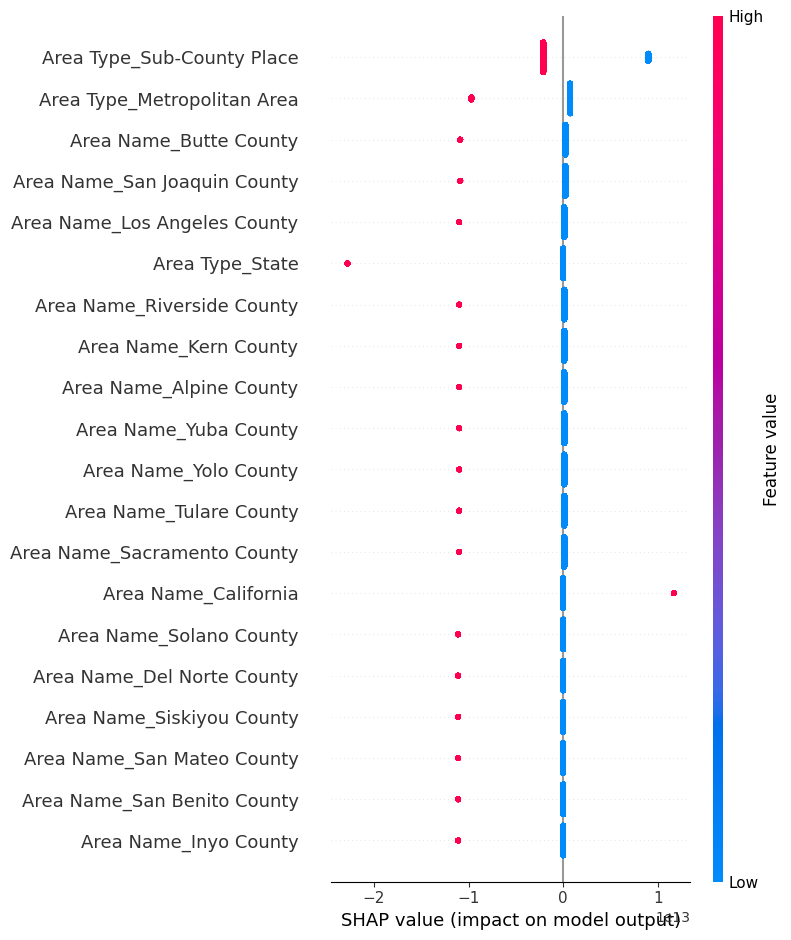

In [ ]:
# Calculate SHAP values
explainer1 = shap.Explainer(model1, X_train)
shap_values1 = explainer1(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values1, X_test, feature_names=X.columns)


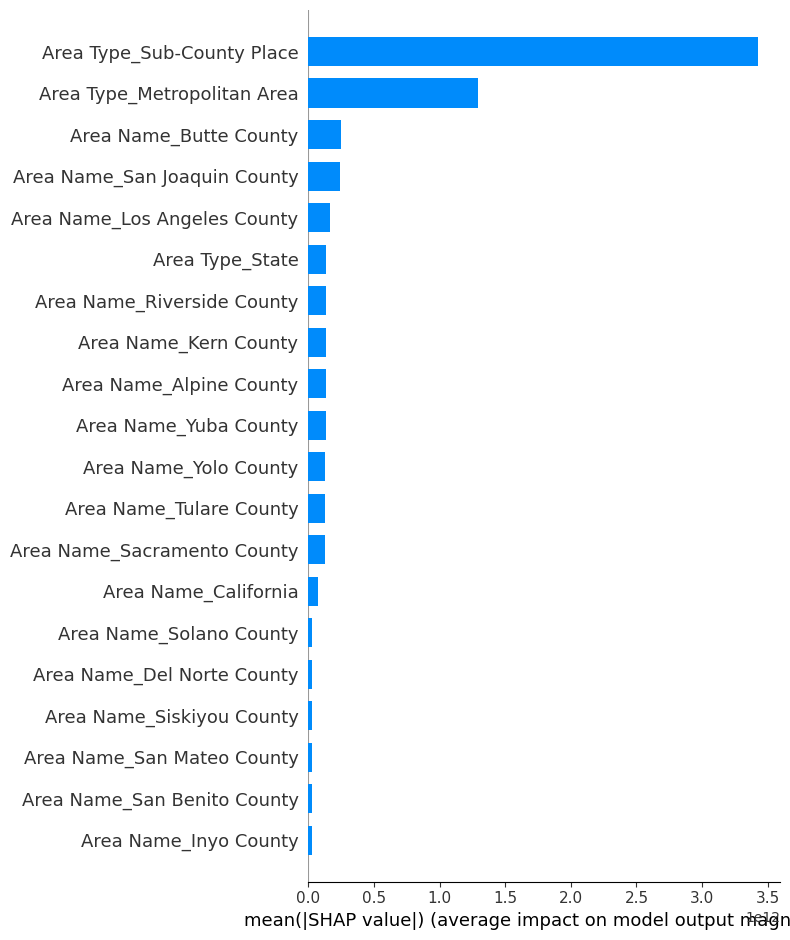

In [ ]:
shap.summary_plot(shap_values1, X_test, feature_names=X.columns, plot_type="bar")

In [ ]:
# Ensure the column count matches the SHAP values
columns_to_use1 = X.columns[:shap_values1.values.shape[1]]

# Convert SHAP values to DataFrame
shap_df1 = pd.DataFrame(shap_values1.values, columns=columns_to_use1)

# Compute mean absolute SHAP value for each feature
feature_importance1 = shap_df1.abs().mean().sort_values(ascending=False)

feature_importance_df1 = feature_importance1.reset_index()
feature_importance_df1.columns = ['Feature', 'Mean Absolute SHAP Value']

print("\nFeature Importance Table:")
print(feature_importance_df1)


Feature Importance Table:
                              Feature  Mean Absolute SHAP Value
0          Area Type_Sub-County Place              3.421811e+12
1         Area Type_Metropolitan Area              1.289828e+12
2              Area Name_Butte County              2.473074e+11
3        Area Name_San Joaquin County              2.415647e+11
4        Area Name_Los Angeles County              1.693509e+11
...                               ...                       ...
1026      Area Name_Castro Valley CDP              1.543556e-05
1027  Area Name_Boyes Hot Springs CDP              1.254999e-05
1028           Area Name_Winters city              8.799905e-06
1029      Area Name_Grover Beach city              7.760081e-06
1030         Area Name_Palo Alto city              3.129444e-06

[1031 rows x 2 columns]


2. Results of shapely value of logistic regression

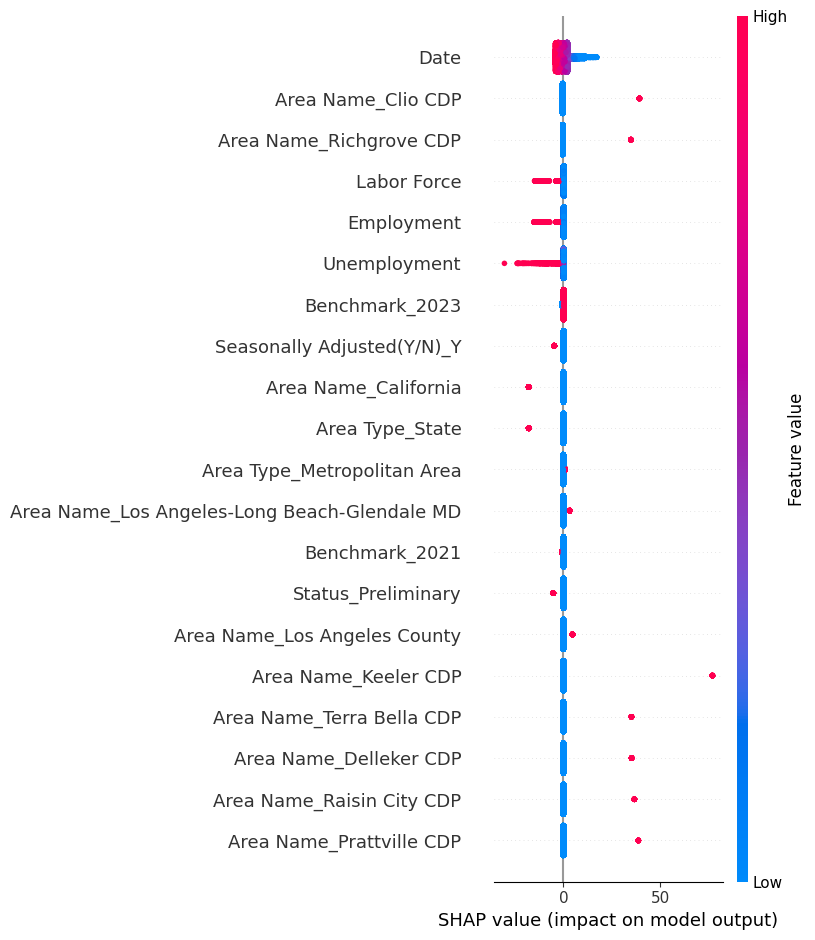

In [ ]:
# Calculate SHAP values
explainer2 = shap.Explainer(model2, X_train)
shap_values2 = explainer2(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values2, X_test, feature_names=X.columns)

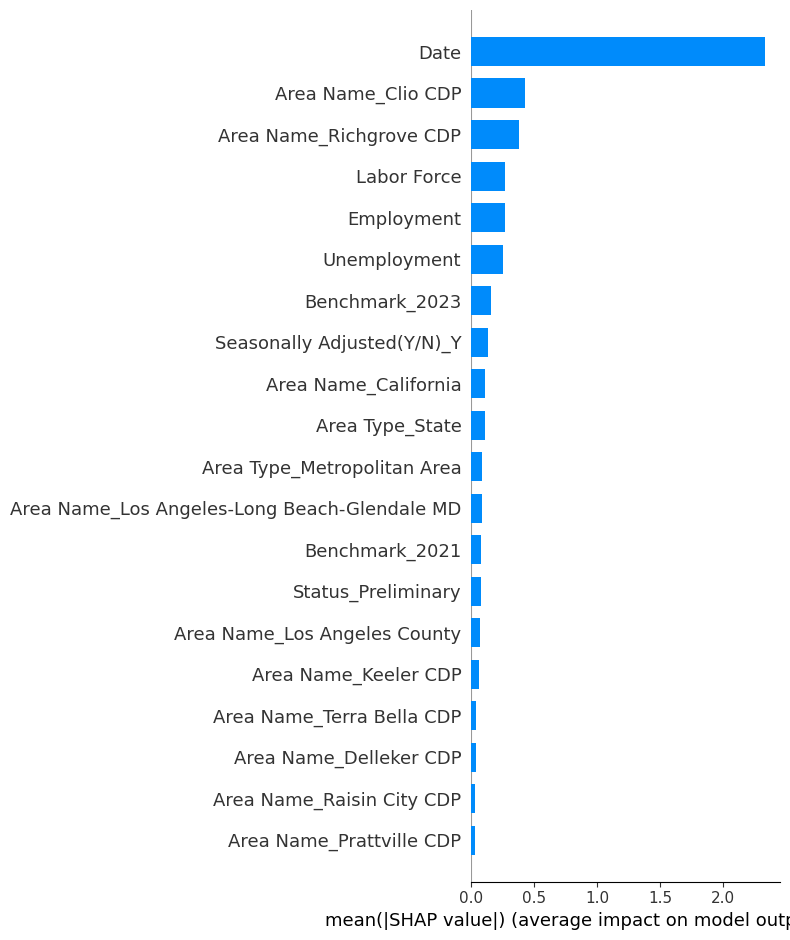

In [ ]:
shap.summary_plot(shap_values2, X_test, feature_names=X.columns, plot_type="bar")

In [ ]:
# Ensure the column count matches the SHAP values
columns_to_use2 = X.columns[:shap_values2.values.shape[1]]

# Convert SHAP values to DataFrame
shap_df2 = pd.DataFrame(shap_values2.values, columns=columns_to_use2)

# Compute mean absolute SHAP value for each feature
feature_importance2 = shap_df2.abs().mean().sort_values(ascending=False)

# Convert to DataFrame
feature_importance_df2 = feature_importance2.reset_index()
feature_importance_df2.columns = ['Feature', 'Mean Absolute SHAP Value']

print("\nFeature Importance Table:")
print(feature_importance_df2)


Feature Importance Table:
                         Feature  Mean Absolute SHAP Value
0                           Date                  2.335965
1             Area Name_Clio CDP                  0.426474
2        Area Name_Richgrove CDP                  0.381298
3                    Labor Force                  0.267186
4                     Employment                  0.266063
...                          ...                       ...
1026       Area Name_Redding MSA                  0.000008
1027     Area Name_Plumas County                  0.000006
1028  Area Name_San Mateo County                  0.000006
1029       Area Name_Fresno city                  0.000003
1030     Area Name_Yuba City MSA                  0.000002

[1031 rows x 2 columns]


# Conclusions

**The linear regression model** is trained to predict the unemployment rate, with non-numeric data converted into boolean features. The results indicate that the model's predictions are strongly influenced by the area. This suggests that the linear model, which typically lacks expressiveness, achieves the lowest loss by adhering to a simple rule: unemployment rates vary significantly across regions. This aligns with the natural tendency of the linear model to capture regional differences as a primary predictor of unemployment rates.


**Logistic regression**, on the other hand, exhibits a different tendency in its predictions. While trained on the same x-data, it aims to classify low and high employment rates by establishing a midpoint within the data. Its predictions also rely heavily on the "date" feature. This result is intuitive, as the classification decision, based on the average unemployment rate, naturally reflects the historical variation of unemployment rates over time, making the "date" feature a key determinant in distinguishing employment trends.